# Import Library dan Load Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 6
plt.style.use('fivethirtyeight')
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
data = pd.read_csv("/content/Electric_Production.csv")

In [ ]:
data

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151
...,...,...
392,09-01-2017,98.6154
393,10-01-2017,93.6137
394,11-01-2017,97.3359
395,12-01-2017,114.7212


In [ ]:
# Rename columns
data.rename(columns={"DATE":"date","Value":"Consumption"}, inplace= True)
data.head()

,date,Consumption
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


# Eksplorasi Data

In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data.isnull().sum()/len(data)

date           0.0
Consumption    0.0
dtype: float64

In [ ]:
data = data.dropna()

In [ ]:
print(data.dtypes)

date            object
Consumption    float64
dtype: object


In [ ]:
data.columns=['Date','Consumption']
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)
data.head()

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


In [ ]:
data.describe()

,Consumption
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [ ]:
data

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


In [ ]:
#Menginisialkan variabel High sebagai data time series
ts = data['Consumption']
ts.head(10)

Date
1985-01-01    72.5052
1985-02-01    70.6720
1985-03-01    62.4502
1985-04-01    57.4714
1985-05-01    55.3151
1985-06-01    58.0904
1985-07-01    62.6202
1985-08-01    63.2485
1985-09-01    60.5846
1985-10-01    56.3154
Name: Consumption, dtype: float64

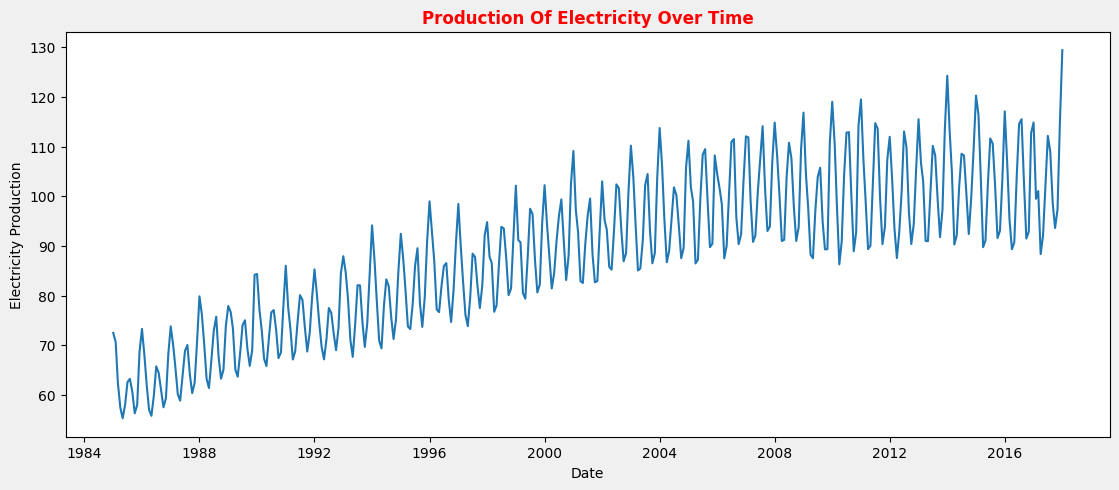

In [ ]:
#Visualisasi dataset
plt.figure(figsize=(12,5))
plt.style.use('default')
plt.xlabel('Date')
plt.ylabel('Electricity Production')
plt.title('Production Of Electricity Over Time',color='red',weight='bold')
plt.plot(data['Consumption'])

## Uji Stasioneritas Data

In [ ]:
#Deklarasi fungsi untuk mengecek stasioneritas data
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()


    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Uji Hipotesis:

H0 : Data tidak stasioner

Ha : Data stasioner

Tolak H0 apabila diperoleh p-value < alpha (0,05)

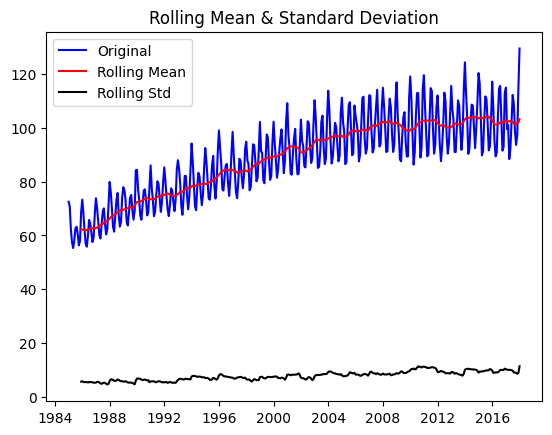

Results of Dickey-Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [ ]:
#Melakukan uji stasioneritas untuk dataset
test_stationarity(ts)

Diperoleh nilai p-value > 0,05, maka H0 tidak ditolak.

Jadi, data memiliki keadaan yang tidak stasioner.

Karena data belum stasioner, sehingga perlu dilakukan proses stasionerisasi data, yakni dengan proses differencing untuk memperoleh data yang stasioner.

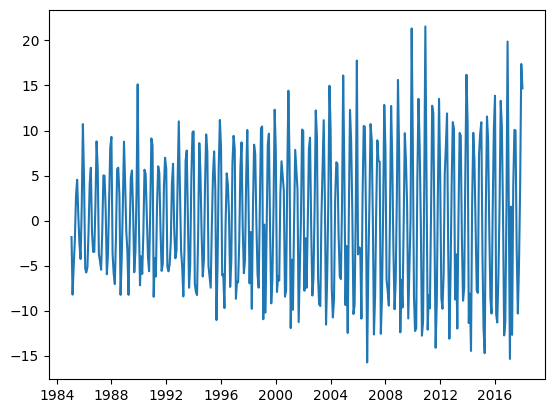

In [ ]:
ts_diff_1 = ts - ts.shift()
ts_diff_1 = ts_diff_1.dropna()
plt.plot(ts_diff_1)

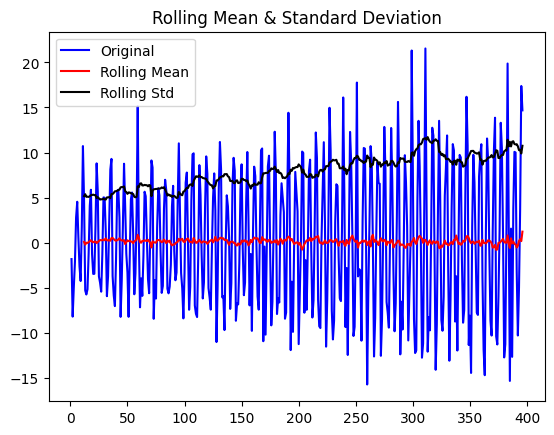

Results of Dickey-Fuller Test:
Test Statistic                -7.104891e+00
p-value                        4.077787e-10
#Lags Used                     1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64


In [ ]:
test_stationarity(ts_diff_1)

Setelah dilakukan proses differencing dan diuji stasioneritas data (setelah differencing), diperoleh data setelah differencing 1x telah membentuk data yang stasioner.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


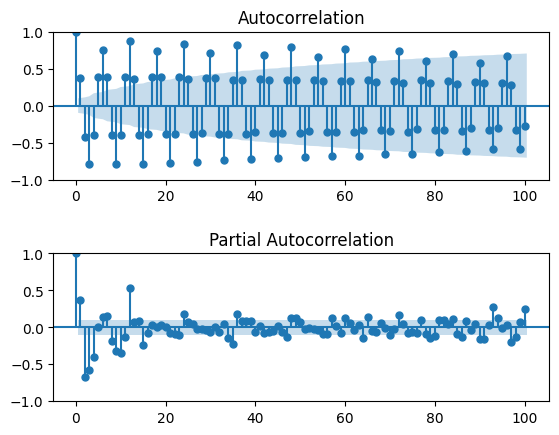

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(ts_diff_1, ax=plt.gca(), lags=100)


plt.subplot(212)
plot_pacf(ts_diff_1, ax=plt.gca(), lags=100)
plt.subplots_adjust(hspace=0.5)  # Mengatur jarak vertikal antara subplot

plt.show()

Plot ACF dan plot PACF dibentuk untuk mengetahui orde dari AR dan MA, sehingga bisa diketahui model yang sesuai untuk data.

In [ ]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.7)               #data trainingnya 70%
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.7 MB/s eta 0:00:00


In [ ]:
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(ts.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=18.542
ARIMA(0, 0, 1) RMSE=11.185
ARIMA(0, 1, 0) RMSE=9.549
ARIMA(0, 1, 1) RMSE=8.052
ARIMA(1, 0, 0) RMSE=9.297
ARIMA(1, 0, 1) RMSE=7.659
ARIMA(1, 1, 0) RMSE=8.824
ARIMA(1, 1, 1) RMSE=8.048
Best ARIMA(1, 0, 1) RMSE=7.659


Setelah dilakukan percobaan dengan model ARIMA(p,d,q) dengan:

- orde p = 0 dan 1
- orde d = 0 dan 1
- orde q = 0 dan 1

Diperoleh model yang menghasilkan RMSE terkecil adalah model ARIMA (1,1,1).

Hal ini sesuai dengan plot ACF dan PACF yang dies down setelah lag ke-1 dan dataset telah mengalami 1x proses differencing.

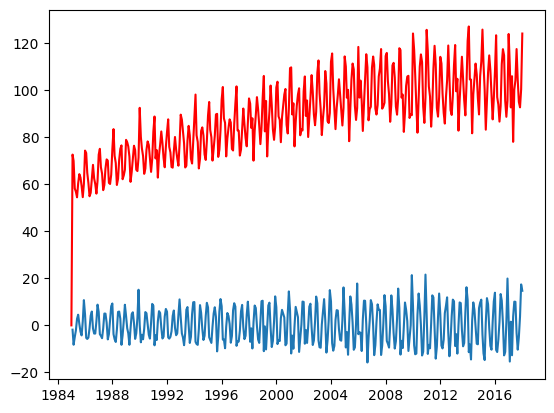

In [ ]:
#Visualisasi perbandingan antara dataset setelah differencing dengan data hasil prediksi ARIMA(1,1,1)
model_ARIMA = ARIMA(ts, order=(1, 1, 1))
results_ARIMA = model_ARIMA.fit()
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues,copy=True)
plt.plot(ts_diff_1)
plt.plot(predictions_ARIMA, color='red')

In [ ]:
#Informasi yang diperoleh dari pemodelan ARIMA(1,1,1) pada dataset
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  397
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1308.795
Date:                Thu, 22 Jun 2023   AIC                           2623.589
Time:                        13:52:41   BIC                           2635.533
Sample:                    01-01-1985   HQIC                          2628.321
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0732      0.091      0.805      0.421      -0.105       0.251
ma.L1          0.5450      0.070      7.737      0.000       0.407       0.683
sigma2        43.4248      3.296     13.175      0.000      36.965      49.885
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 1.44
Prob(Q):                              0.72   Prob(JB):                         0.49
Heteroskedasticity (H):               2.97   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Prediksi Data

In [ ]:
predict_dif = results_ARIMA.predict(start=len(ts), end=len(ts)+83)  # Mengubah parameter start dan end (memprediksi 7 tahun kedepan hingga 2024)
predictions_dif_cum_sum = predict_dif.cumsum()
pred_ts = [ts[-1]]
for i, j in enumerate(predictions_dif_cum_sum):
    a = pred_ts[i] + j
    pred_ts.append(a)
predict = pd.Series(pred_ts[1:], index=pd.date_range(start=ts.index[-1], periods=len(pred_ts)-1, freq='MS'))  # Mengubah index menjadi periode yang sesuai
print(predict)

In [ ]:
predict_dif = results_ARIMA.predict(start=len(ts), end=len(ts)+11)  # Memprediksi 12 bulan ke depan
predictions_dif_cum_sum = predict_dif.cumsum()
pred_ts = [ts[-1]]
for i, j in enumerate(predictions_dif_cum_sum):
    a = pred_ts[i] + j
    pred_ts.append(a)
predict = pd.Series(pred_ts[1:], index=pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=len(pred_ts)-1, freq='MS'))  # Menggunakan pd.DateOffset(months=1) untuk mulai prediksi setelah data terakhir
print(predict)

2018-02-01      262.881901
2018-03-01      530.134155
2018-04-01      931.183379
2018-05-01     1466.031167
2018-06-01     2134.677638
2018-07-01     2937.122799
2018-08-01     3873.366651
2018-09-01     4943.409195
2018-10-01     6147.250429
2018-11-01     7484.890356
2018-12-01     8956.328973
2019-01-01    10561.566282
Freq: MS, dtype: float64


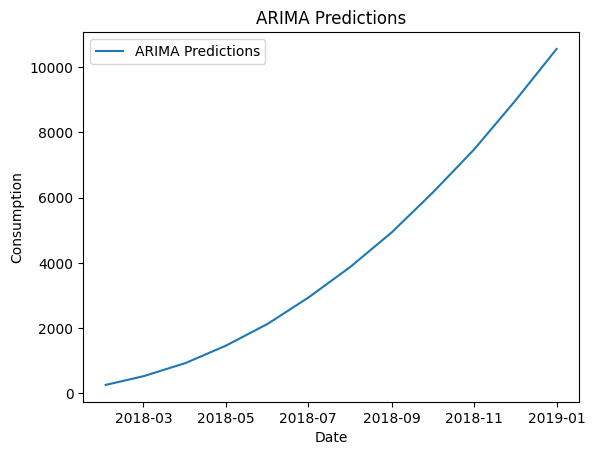

In [ ]:
import matplotlib.pyplot as plt

# Check if ts has any data
if len(ts) > 0:
    predict_dif = results_ARIMA.predict(start=len(ts), end=len(ts)+11)  # Memprediksi 12 bulan ke depan
    predictions_dif_cum_sum = predict_dif.cumsum()
    pred_ts = [ts.iloc[-1]]  # Menggunakan .iloc[-1] untuk mengakses nilai terakhir
    for i, j in enumerate(predictions_dif_cum_sum):
        a = pred_ts[i] + j
        pred_ts.append(a)

    plt.plot(predict, label='ARIMA Predictions')

    plt.xlabel('Date')
    plt.ylabel('Consumption')
    plt.title('ARIMA Predictions')
    plt.legend()
    plt.show()

In [ ]:
''''import pandas as pd
import matplotlib.pyplot as plt

# Check if ts has any data
if len(ts) > 0:
    predict_dif = results_ARIMA.predict(start=len(ts), end=len(ts)+83)
    predictions_dif_cum_sum = predict_dif.cumsum()
    pred_ts = [ts.iloc[-1]]  # Use .iloc[-1] instead of ts[-1] to access the last value
    for i, j in enumerate(predictions_dif_cum_sum):
        a = pred_ts[i] + j
        pred_ts.append(a)
    predict = pd.Series(pred_ts[1:], index=pd.date_range(start=ts.index[-1], periods=len(pred_ts)-1, freq='MS'))

    # Visualize the original data and predictions
    plt.plot(ts, label='Original Data')
    plt.plot(predict, label='ARIMA Predictions')

    plt.xlabel('Date')
    plt.ylabel('Consumption')
    plt.title('ARIMA Predictions')
    plt.legend()
    plt.show()
else:
    print("No data available for predictions.")

In [ ]:
''''import pandas as pd
import matplotlib.pyplot as plt

# Memprediksi hingga tahun 2024
start_pred = len(ts) - 1
end_pred = len(ts) + 680 # Prediksi hingga 83 periode (83 bulan) setelah data terakhir

predict_dif = results_ARIMA.predict(start=start_pred, end=end_pred)
predictions_dif_cum_sum = predict_dif.cumsum()
pred_ts = [ts.iloc[-1]]  # Menggunakan .iloc[-1] untuk mengakses nilai terakhir
for i, j in enumerate(predictions_dif_cum_sum):
    a = pred_ts[i] + j
    pred_ts.append(a)
predict = pd.Series(pred_ts[1:], index=pd.date_range(start=ts.index[-1], periods=len(pred_ts)-1, freq='MS'))

# Visualisasi data asli dan prediksi
plt.plot(ts, label='Original Data')
plt.plot(predict, label='ARIMA Predictions')

plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('ARIMA Predictions')
plt.legend()
plt.show()


Diperoleh hasil prediksi Konsumsi listrik 7 tahun kedepan pada periode tanggal :

*   2018-01-01       262.881901
*  2018-02-01 = 530.134155
*  2018-03-01 = 931.183379
*   2018-04-01 = 1466.031167
*   2018-05-01 = 2134.677638

*   2024-08-01 = 433609.433013
*   2024-09-01 = 444446.780020
*   2024-10-01  =  455417.925719
*   2024-11-01  = 466522.870108
*   2024-12-01   = 477761.613189

**dan didaptkan Best ARIMA(1, 0, 1) RMSE=7.659**
